**FCN:**
* remove any dense(fully connected) layers and only use convolution layers.
* downsampling and then do upsampling to get pixel wise prediction to do segmentation.
* also introduce lateral connections, which is combining downsampling feature map and upasmpled feature map on same level.
* when combining lateral connections, the paper simply adds the two.
* upsampling is a layer which is initialized as bilinear interpolation but allow the params to be learned.

**UNet:**
* down and upsampling architecture.
* only the final upsampled feature map is utilized.
* designed for segmentation.

import essential libraries:

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers


import 'oxford_iiit_pet' dataset for training:

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

resize the images and masks to 128x128:

In [3]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

create a function to augment the dataset by flipping them horizontally:

In [4]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

normalize the dataset by scaling the images to the range of [-1, 1] and decreasing the image mask by 1:

In [5]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

functions to preprocess the training and test datasets:

In [6]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

build an input pipeline:

In [7]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

making dataset ready for training:

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

visualize a random sample image and its mask from the training dataset:

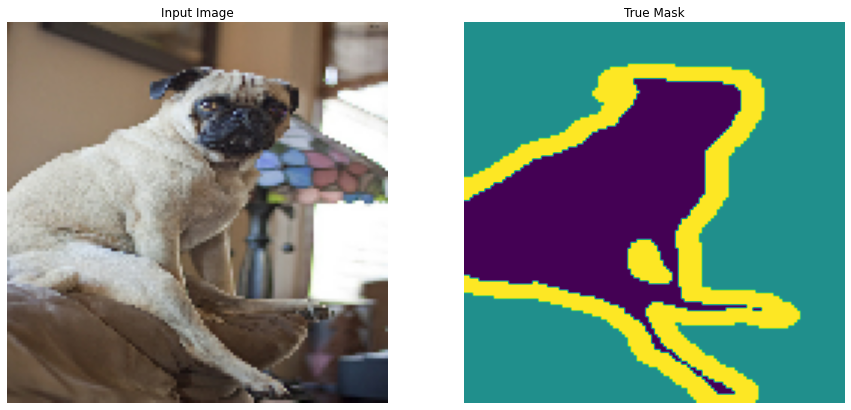

In [14]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

building blocks:

In [15]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [16]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [17]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

Unet model:

In [13]:
def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [14]:
unet_model = build_unet_model()

compile and train Unet:

In [15]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [16]:
NUM_EPOCHS = 10

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/10
57/57 [==============================] - 162s 2s/step - loss: 2.1894 - accuracy: 0.5593 - val_loss: 0.9181 - val_accuracy: 0.5864
Epoch 2/10
57/57 [==============================] - 130s 2s/step - loss: 0.8967 - accuracy: 0.6057 - val_loss: 0.8755 - val_accuracy: 0.5864
Epoch 3/10
57/57 [==============================] - 120s 2s/step - loss: 0.7823 - accuracy: 0.6693 - val_loss: 0.7104 - val_accuracy: 0.7190
Epoch 4/10
57/57 [==============================] - 121s 2s/step - loss: 0.6857 - accuracy: 0.7217 - val_loss: 0.6645 - val_accuracy: 0.7264
Epoch 5/10
57/57 [==============================] - 121s 2s/step - loss: 0.6481 - accuracy: 0.7387 - val_loss: 0.6407 - val_accuracy: 0.7337
Epoch 6/10
57/57 [==============================] - 120s 2s/step - loss: 0.6147 - accuracy: 0.7520 - val_loss: 0.6235 - val_accuracy: 0.7424
Epoch 7/10
57/57 [==============================] - 121s 2s/step - loss: 0.5955 - accuracy: 0.7619 - val_loss: 0.6218 - val_accuracy: 0.7432
Epoch 8/10
57

Unet prediction:

In [54]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def show_predictions_unet(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


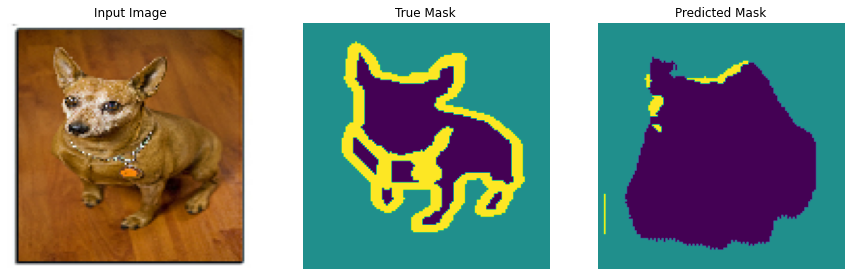

In [18]:
show_predictions_unet(test_batches)

fcn model:

In [48]:
def build_fcn_model():
   # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 128)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 128)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 128)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 512)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 128)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 128)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 128)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # fcn model with Keras Functional API
   fcn_model = tf.keras.Model(inputs, outputs, name="FCN")

   return fcn_model

In [49]:
fcn_model = build_fcn_model()

compile and train fcn model:

In [50]:
fcn_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [51]:
NUM_EPOCHS = 10

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = fcn_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/10
57/57 [==============================] - 278s 5s/step - loss: 0.9992 - accuracy: 0.5656 - val_loss: 0.8899 - val_accuracy: 0.5864
Epoch 2/10
57/57 [==============================] - 180s 3s/step - loss: 0.8151 - accuracy: 0.6151 - val_loss: 0.7467 - val_accuracy: 0.6691
Epoch 3/10
57/57 [==============================] - 173s 3s/step - loss: 0.6820 - accuracy: 0.7131 - val_loss: 0.6134 - val_accuracy: 0.7567
Epoch 4/10
57/57 [==============================] - 173s 3s/step - loss: 0.6216 - accuracy: 0.7513 - val_loss: 0.5687 - val_accuracy: 0.7751
Epoch 5/10
57/57 [==============================] - 173s 3s/step - loss: 0.5564 - accuracy: 0.7818 - val_loss: 0.5354 - val_accuracy: 0.7920
Epoch 6/10
57/57 [==============================] - 173s 3s/step - loss: 0.5262 - accuracy: 0.7964 - val_loss: 0.5607 - val_accuracy: 0.7842
Epoch 7/10
57/57 [==============================] - 173s 3s/step - loss: 0.4887 - accuracy: 0.8114 - val_loss: 0.4386 - val_accuracy: 0.8287
Epoch 8/10
57

prediction by fcn:

In [52]:
def show_predictions_fcn(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = fcn_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

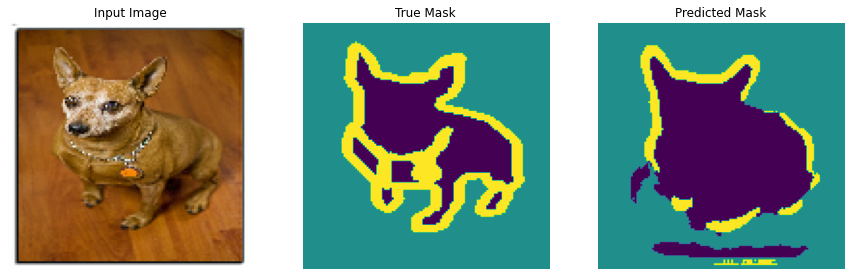

In [55]:
show_predictions_fcn(test_batches)

the accuracy and validation accuracy for fcn model is greater than model for nearly 3 percents.